In [27]:
import json
import os
import numpy as np
import math
from collections import defaultdict

### Load Data
Load the dictionarry with results for all Mamba and GPT models across all four sessions

In [5]:
with open("correlation_dictionary_final_updated.json", "r", encoding="utf-8-sig") as f:
    data = json.load(f)

In [6]:
# The ROIS
data.keys()

dict_keys(['Amygdala_L.npz', 'Amygdala_R.npz', 'Angular_L.npz', 'Angular_R.npz', 'Calcarine_L.npz', 'Calcarine_R.npz', 'Caudate_L.npz', 'Caudate_R.npz', 'Cingulum_Ant_L.npz', 'Cingulum_Ant_R.npz', 'Cingulum_Mid_L.npz', 'Cingulum_Mid_R.npz', 'Cingulum_Post_L.npz', 'Cingulum_Post_R.npz', 'Cuneus_L.npz', 'Cuneus_R.npz', 'Frontal_Inf_Oper_L.npz', 'Frontal_Inf_Oper_R.npz', 'Frontal_Inf_Orb_L.npz', 'Frontal_Inf_Orb_R.npz', 'Frontal_Inf_Tri_L.npz', 'Frontal_Inf_Tri_R.npz', 'Frontal_Med_Orb_L.npz', 'Frontal_Med_Orb_R.npz', 'Frontal_Mid_L.npz', 'Frontal_Mid_Orb_L.npz', 'Frontal_Mid_Orb_R.npz', 'Frontal_Mid_R.npz', 'Frontal_Sup_L.npz', 'Frontal_Sup_Medial_L.npz', 'Frontal_Sup_Medial_R.npz', 'Frontal_Sup_Orb_L.npz', 'Frontal_Sup_Orb_R.npz', 'Frontal_Sup_R.npz', 'Fusiform_L.npz', 'Fusiform_R.npz', 'Heschl_L.npz', 'Heschl_R.npz', 'Hippocampus_L.npz', 'Hippocampus_R.npz', 'Insula_L.npz', 'Insula_R.npz', 'Lingual_L.npz', 'Lingual_R.npz', 'Occipital_Inf_L.npz', 'Occipital_Inf_R.npz', 'Occipital_Mid_L.

In [262]:
def compute_weighted_stats(area_dict):
    subjects = area_dict["subjects"]

    # Collect model types & conditions
    model_types = set()
    conditions = set()

    for subj, info in subjects.items():
        for m in info["model_type"]:
            model_types.add(m)
            conditions.update(info["model_type"][m].keys())

    results = {m: {} for m in model_types}

    for model in model_types:
        for cond in conditions:
            values = []      # subject-level scores
            weights = []     # voxel counts
            subj_ids = []    # track subject names (optional)

            for subj, info in subjects.items():
                if model not in info["model_type"]:
                    continue
                if cond not in info["model_type"][model]:
                    continue

                value = info["model_type"][model][cond]
                if value is None or (isinstance(value, float) and math.isnan(value)):
                    continue

                w = info["voxel_count"]
                values.append(value)
                weights.append(w)
                subj_ids.append(subj)

            if len(values) == 0:
                results[model][cond] = {"mean": None, "sem": None, "values": [], "weights": []}
                continue

            # Weighted mean
            W = sum(weights)
            mean = sum(w * x for w, x in zip(weights, values)) / W

            # Weighted variance
            var = sum(w * (x - mean)**2 for w, x in zip(weights, values)) / W

            # Effective sample size
            Neff = (W**2) / sum(w**2 for w in weights)

            # Weighted SEM
            sem = math.sqrt(var / Neff) if Neff > 1 else None

            results[model][cond] = {
                "mean": mean,
                "sem": sem,
                "values": values,     # <-- needed for significance testing
                "weights": weights,   # <-- optional but useful
                "subjects": subj_ids  # <-- optional, helpful for debugging
            }

    return results

### Combine ROIs
Comine L and R for each ROI and different sub ROIs iunto the IFG / Anterior Temporal Lobe / ..

In [227]:
def strip_lr(name):
    # First, map IFG subregions to Frontal_Inf
    if any(sub in roi_name for sub in ["Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R", "Frontal_Inf_Oper", "Frontal_Inf_Tri"]):
        return "Frontal_Inf"

    if any(sub in roi_name for sub in ['Temporal_Mid_L.npz', 'Temporal_Mid_R.npz',
         'Temporal_Inf_L.npz', 'Temporal_Inf_R.npz',
         'Temporal_Sup_L.npz', 'Temporal_Sup_R.npz']):
        return "Posterior_Temporal_Lobe"
        
    if any(sub in roi_name for sub in ["Temporal_Pole_Sup_L",
                "Temporal_Pole_Sup_R", "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R"]):
        return "AntTemp"
        
    if any(sub in roi_name for sub in ['Frontal_Sup_Medial_L.npz', 'Frontal_Sup_Medial_R.npz']):
        return "dmPFC"
        
    """Remove _L or _R if present."""
    if name.endswith("_L.npz"):
        return name.replace("_L.npz", "")
    if name.endswith("_R.npz"):
        return name.replace("_R.npz", "")
    if name.endswith("_L"):
        return name[:-2]
    if name.endswith("_R"):
        return name[:-2]
    return name

In [228]:
merged_areas = defaultdict(lambda: {"subjects": defaultdict(lambda: {"model_type": defaultdict(dict),
                                                                    "voxel_count": 0})})

In [265]:
for roi_name, roi_data in data.items():
    merged_name = strip_lr(roi_name)

    for subj, subj_data in roi_data["subjects"].items():
        merged_subj = merged_areas[merged_name]["subjects"][subj]

        # Add voxel counts (L+R)
        merged_subj["voxel_count"] += subj_data["voxel_count"]

        # Merge model types + conditions
        for model, conds in subj_data["model_type"].items():
            for cond_name, value in conds.items():
                # If value is NaN, treat as missing (skip)
                if value is None or (isinstance(value, float) and math.isnan(value)):
                    continue
                merged_subj["model_type"][model][cond_name] = value

In [266]:
# ---- Process all brain areas ----
merged_results = {
    area: compute_weighted_stats(info)
    for area, info in merged_areas.items()
}

In [479]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgb

def lighten(color, amount=0.9):
    """Return a lighter shade of a given color."""
    c = np.array(to_rgb(color))
    white = np.array([1, 1, 1])
    return tuple(c + (white - c) * amount)

from scipy.stats import ttest_rel

def plot_models(merged_results, ncs, rois=None, conditions=None, alpha=0.05):
    """
    Plot mean ± SEM with significance testing between conditions within each ROI.
    """

    # Filter ROIs
    if rois is None:
        rois = list(merged_results.keys())

    models = ["gpt", "mamba"]

    # Colors for models
    model_colors = {
        "gpt": "#1f77b4",    # blue
        "mamba": "#d62728"   # red
    }

    # Gather all condition names if not provided
    if conditions is None:
        conditions = sorted({
            cond
            for roi in rois if roi in merged_results
            for model in merged_results[roi]
            for cond in merged_results[roi][model]
        })

    plt.figure(figsize=(16, 8), dpi=150)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    bar_width = 0.2
    for x in np.arange(len(rois)) + 0.5:
        plt.axvline(x, color="gray", lw=0.3, alpha=0.4)

    x_positions = np.arange(len(rois))*1.5

    legend_items = []
    significance_results = []  # store test outcomes

    for model_index, model in enumerate(models):

        for cond_index, cond in enumerate(conditions):
            means = []
            sems = []

            for ii, roi in enumerate(rois):

                if roi not in merged_results or model not in merged_results[roi]:
                    means.append(np.nan)
                    sems.append(np.nan)
                    continue

                entry = merged_results[roi][model].get(cond, None)
                if entry is None:
                    means.append(np.nan)
                    sems.append(np.nan)
                    continue

                means.append(entry["mean"] / ncs[ii])
                sems.append(entry["sem"] / ncs[ii])

            # bar shift
            shift = (model_index * len(conditions) + cond_index -
                     (len(models)*len(conditions))/2) * bar_width

            # shade color
            shade_frac = 0.45 * cond_index
            color = lighten(model_colors[model], amount=shade_frac)

            plt.bar(
                x_positions + shift, means,
                width=bar_width,
                yerr=sems,
                capsize=3,
                color=color,
                edgecolor='black'
            )

            legend_items.append((color, f"{model}: {cond}"))

    # -------- SIGNIFICANCE TESTING --------
    print("\n\n=== SIGNIFICANCE TESTS (paired t-tests per ROI) ===")

    for roi in rois:
        if roi not in merged_results:
            continue

        # Example: compare the first and second condition
        if len(conditions) < 2:
            continue

        condA, condB = conditions[0], conditions[1]

        for model in models:
            if model not in merged_results[roi]:
                continue
            if condA not in merged_results[roi][model]:
                continue
            if condB not in merged_results[roi][model]:
                continue

            valsA = np.array(merged_results[roi][model][condA]["values"])
            valsB = np.array(merged_results[roi][model][condB]["values"])

            # Drop missing subjects
            mask = np.isfinite(valsA) & np.isfinite(valsB)
            valsA = valsA[mask]
            valsB = valsB[mask]

            if len(valsA) < 2:
                continue

            tval, pval = ttest_rel(valsA, valsB)
            significance_results.append((roi, model, condA, condB, pval))

            print(f"{roi} | {model} | {condA} vs {condB}: p = {pval:.4g}")

    # -------- PLOT LABELS --------
    plt.xticks(x_positions, rois, rotation=45, ha='right')
    plt.ylabel("Normalized Mean ± SEM")
    plt.ylim(bottom=-0.03,top=0.04)
    plt.grid(axis='y', linestyle='--', alpha=0.35)
    plt.title("Large Models",fontsize=20)

    # Legend
    unique_labels = {}
    for color, label in legend_items:
        unique_labels[label] = color

    handles = [plt.Rectangle((0, 0), 1, 1, color=color)
               for color in unique_labels.values()]
    plt.legend(handles, unique_labels.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.savefig("large_models_figure1.png", dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()


    return significance_results



=== SIGNIFICANCE TESTS (paired t-tests per ROI) ===
Frontal_Inf | gpt | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.2177
Frontal_Inf | mamba | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.7197
Frontal_Inf_Orb | gpt | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.08675
Frontal_Inf_Orb | mamba | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.183
Cingulum_Post | gpt | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.1812
Cingulum_Post | mamba | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10percent_test: p = 0.3665
AntTemp | gpt | concat_correlation_large_20_words_10percent_test vs scrambled_correlation_large_20_words_10perce

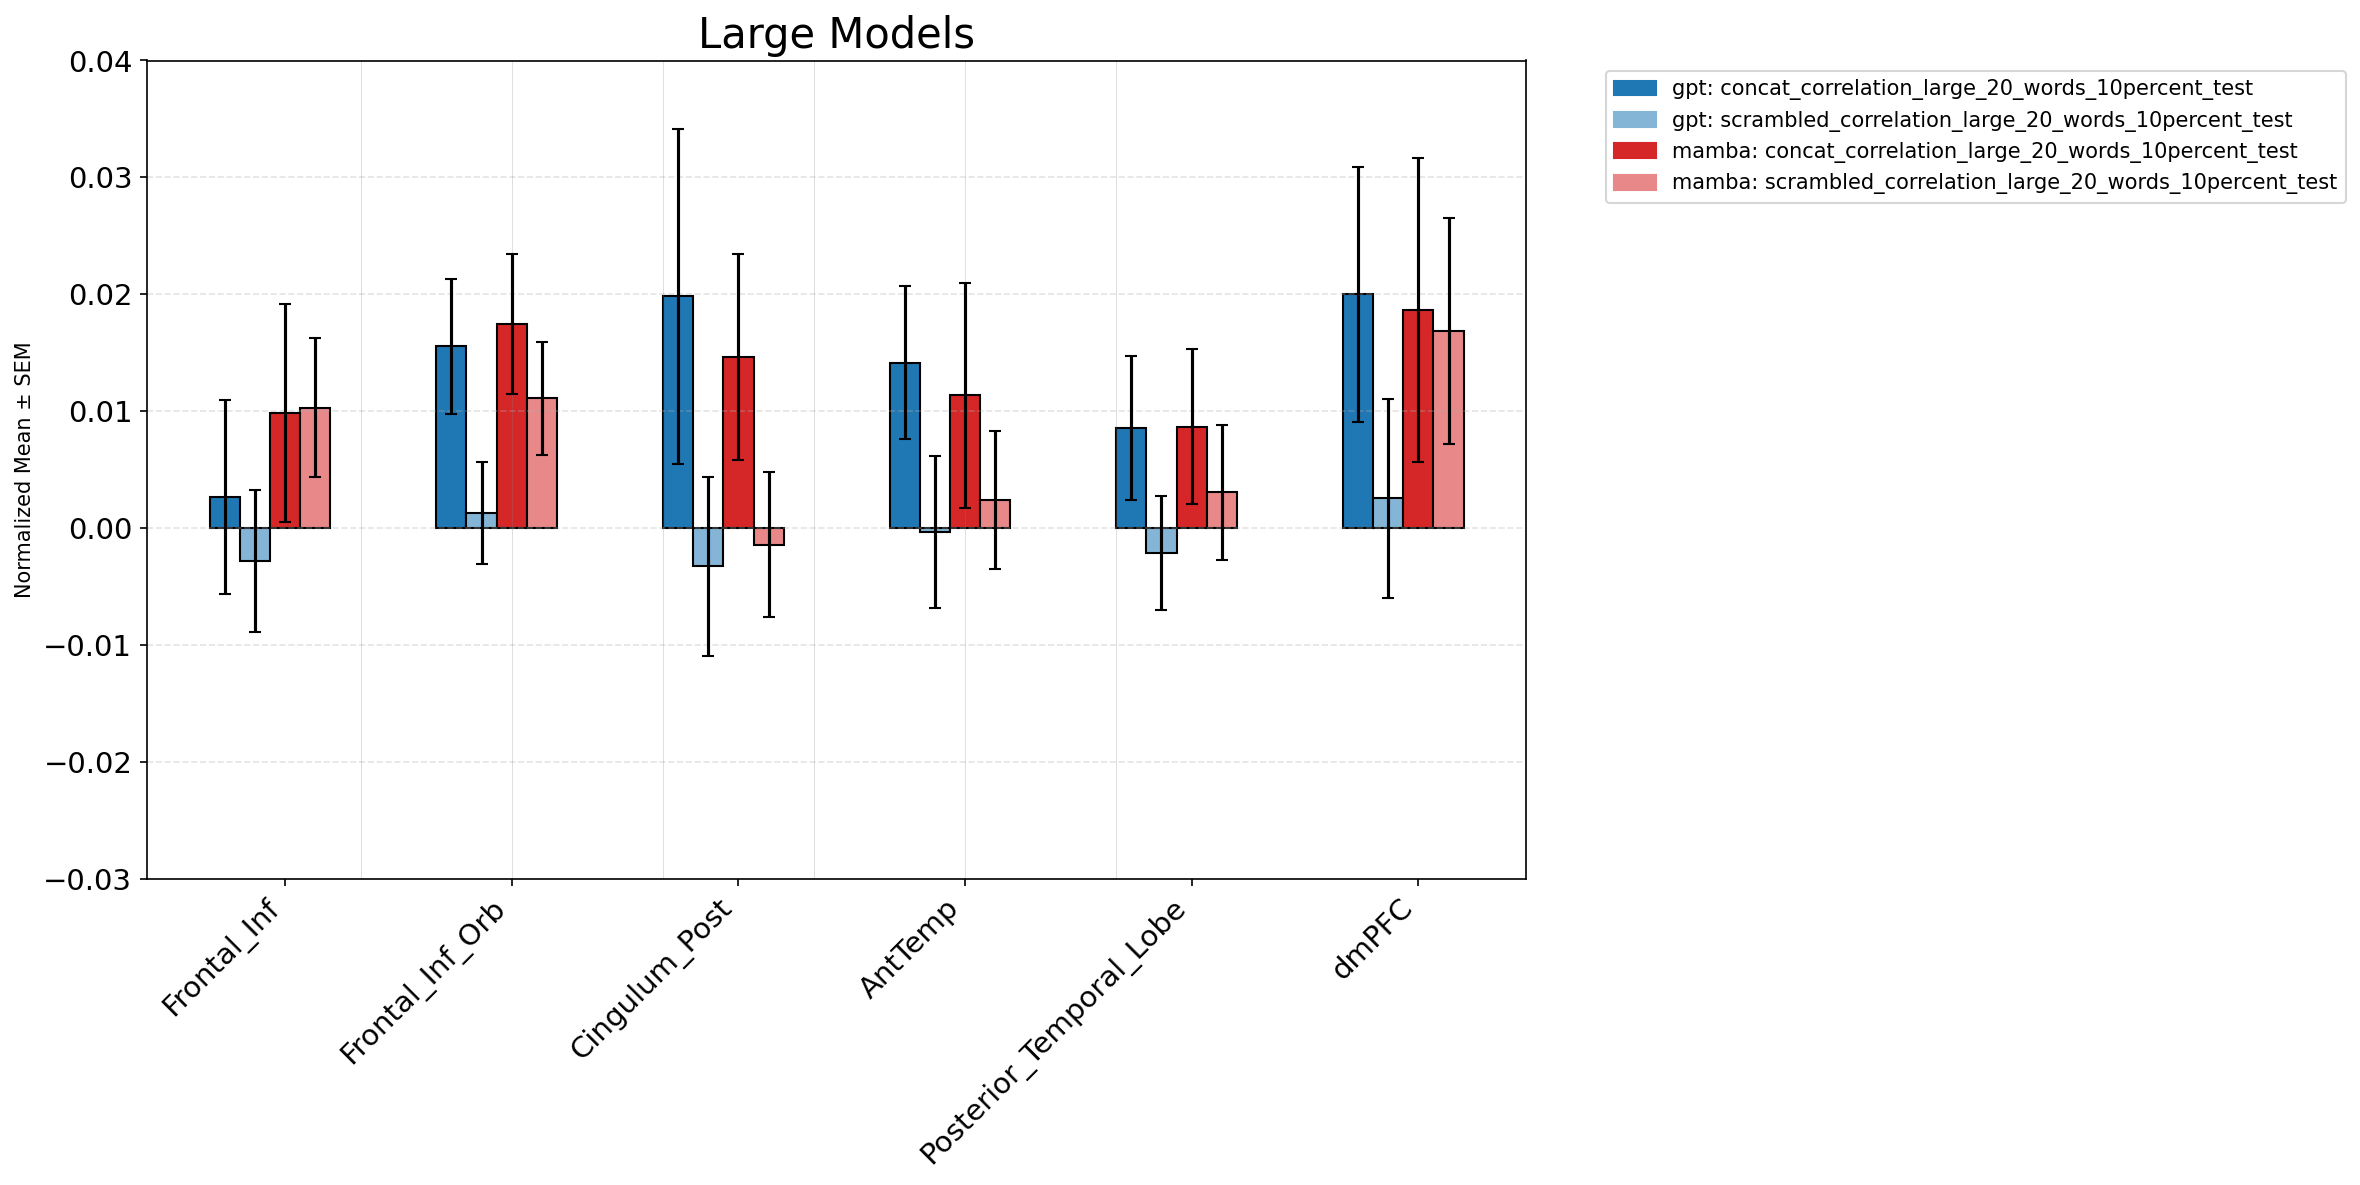

[('Frontal_Inf',
  'gpt',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words_10percent_test',
  np.float64(0.21774128712375604)),
 ('Frontal_Inf',
  'mamba',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words_10percent_test',
  np.float64(0.7196513505702284)),
 ('Frontal_Inf_Orb',
  'gpt',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words_10percent_test',
  np.float64(0.08674795346352165)),
 ('Frontal_Inf_Orb',
  'mamba',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words_10percent_test',
  np.float64(0.1830358424752476)),
 ('Cingulum_Post',
  'gpt',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words_10percent_test',
  np.float64(0.18120753809793913)),
 ('Cingulum_Post',
  'mamba',
  'concat_correlation_large_20_words_10percent_test',
  'scrambled_correlation_large_20_words

In [480]:
rois=["Angular","Frontal_Mid","Frontal_Inf", "Cingulum_Post", "AntTemp",
      "Frontal_Mid", "Frontal_Inf_Orb", "Posterior_Temporal_Lobe", "dmPFC"]
rois=["Frontal_Inf", "Frontal_Inf_Orb", "Cingulum_Post", "AntTemp",
      "Posterior_Temporal_Lobe", "dmPFC"]
# These noise ceiling values are from the 
ncs = [0.65,0.7,0.5895,0.7,0.7556,0.574]
conditions=["concat_correlation_large_20_words_10percent_test",
          "scrambled_correlation_large_20_words_10percent_test"]
plot_models(merged_results,ncs,rois,conditions)

## Noise Ceiling Calculation
Below are two ways to get LNC: 
1) just by looking at correlation between activations of a subject vs the average activations of all others
2) learning a regression between the two and taking correlation between predicted and ground truth activations
The NC method used is not actually important in this case as we 

In [375]:
import os
import numpy as np
from scipy.linalg import orthogonal_procrustes

def lower_noise_ceiling_pca(rois, subjects, basedir="./ROIs", n_components=15, align_iterations=3):
    """
    Computes PCA/SVD-based lower noise ceiling for a set of ROIs across subjects.
    - Merges multiple ROIs (e.g., ['Angular_L','Angular_R']) per subject.
    - Projects voxel x time matrix to top n_components temporal components.
    - Aligns components across subjects using orthogonal Procrustes.
    - Computes correlation between each subject and the weighted mean of other subjects.
    
    Returns:
        nc_per_subject: dict {subject: lower noise ceiling}
        roi_nc_mean: mean lower noise ceiling across subjects
    """

    subj_proj = {}  # subject -> (n_components x time)
    sub_test = {}
    subj_vox = {}   # total voxels per subject

    # Step 1: load and merge ROIs
    for subj in subjects:
        mats = []
        mats_tst = []
        for roi in rois:
            path = os.path.join(basedir, subj, f"{roi}_{subj}.npz")
            if not os.path.exists(path):
                continue
            arr = np.load(path, allow_pickle=True)
            if "arr_0" not in arr:
                continue
            d = arr['arr_0'][()]
            roi_arrays = [d[ii] for ii in [1,2,3]]
            roi_test   = d[4]
            # check all time dimensions are equal
            T_set = {a.shape[1] for a in roi_arrays}
            if len(T_set) != 1:
                continue
            mats.append(np.vstack(roi_arrays).T)  # vox x time
            mats_tst.append(np.vstack(roi_test).T)  # vox x time
            #print(mats[-1].shape)

        if len(mats) == 0:
            continue  # skip subject missing all ROIs

        mat = np.vstack(mats)
        mat_tst = np.vstack(mats_tst)
        if mat.shape[0] < 2 or mat.shape[1] < 2:
            continue

        subj_vox[subj] = mat.shape[0]

        # PCA via SVD
        U, S, Vt = np.linalg.svd(mat, full_matrices=False)
        ncomp = min(n_components, Vt.shape[0])
        subj_proj[subj] = Vt[:ncomp, :]  # ncomp x time

    subs = list(subj_proj.keys())
    if len(subs) < 2:
        return {}, np.nan

    # Step 2: align components across subjects using orthogonal Procrustes
    # Initialize reference as mean of all subjects
    max_comp = max(c.shape[0] for c in subj_proj.values())
    # pad components to max_comp
    def pad(comps, target):
        c, t = comps.shape
        if c < target:
            padarr = np.zeros((target - c, t))
            return np.vstack([comps, padarr])
        return comps

    padded_proj = {s: pad(subj_proj[s], max_comp) for s in subs}
    ref = np.mean(list(padded_proj.values()), axis=0)

    for _ in range(align_iterations):
        aligned = {}
        for s in subs:
            # Orthogonal Procrustes: aligns subject's component space to reference
            R, _ = orthogonal_procrustes(padded_proj[s].T, ref.T)
            aligned[s] = (R.T @ padded_proj[s])
        ref = np.mean(list(aligned.values()), axis=0)
    aligned_proj = {s: aligned[s][:subj_proj[s].shape[0], :] for s in subs}  # truncate to original n_components

    # Step 3: compute lower noise ceiling per subject
    nc_per_subject = {}
    for s in subs:
        others = [o for o in subs if o != s]
        weights = np.array([subj_vox[o] for o in others], dtype=float)
        # weighted mean of others
        others_mats = [aligned_proj[o] for o in others]
        weighted_mean_other = np.average(np.stack(others_mats, axis=0), axis=0, weights=weights)
        # correlate flattened vectors
        vec_s = aligned_proj[s].ravel() - np.mean(aligned_proj[s])
        vec_o = weighted_mean_other.ravel() - np.mean(weighted_mean_other)
        print(vec_s.shape,vec_o.shape)
        denom = np.sqrt(np.sum(vec_s**2) * np.sum(vec_o**2))
        r = np.nan if denom == 0 else np.sum(vec_s * vec_o) / denom
        nc_per_subject[s] = float(r)

    roi_nc_mean = float(np.nanmean(list(nc_per_subject.values())))
    return nc_per_subject, roi_nc_mean

In [376]:
subjs = ['subj1','subj2','subj3','subj4','subj5','subj6','subj7','subj8']
nc_per_subject, roi_nc = lower_noise_ceiling_pca(['Temporal_Mid_L', 'Temporal_Mid_R',
         'Temporal_Inf_L', 'Temporal_Inf_R',
         'Temporal_Sup_L', 'Temporal_Sup_R'], subjs, basedir="./ROIs", n_components=10)

(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)
(9260,) (9260,)


In [450]:
import os
import numpy as np
from scipy.linalg import orthogonal_procrustes
from sklearn.linear_model import Ridge

def zscore_rows(X, eps=1e-8):
    m = X.mean(axis=1, keepdims=True)
    s = X.std(axis=1, keepdims=True)
    return (X - m) / (s + eps)

def ridge_noise_ceiling_pca(rois, subjects, basedir="./ROIs",
                             n_components=15, align_iterations=3, alpha=10.0):
    """
    Computes a ridge-regression based lower noise ceiling:
      - Train ridge model to predict left-out subject TRAIN components
      - Test on left-out subject TEST components
      - Report correlation(predicted_test, actual_test)

    Returns:
        nc_test_pred_per_subject : dict {subject: correlation}
        test_mean: mean across subjects
    """

    subj_train = {}      # subject -> (ncomp x time)
    subj_testproj = {}   # subject -> (ncomp x time)
    subj_U = {}
    subj_vox = {}

    # ---------- Step 1: Load and PCA ----------
    for subj in subjects:
        mats = []
        mats_tst = []
        for roi in rois:
            path = os.path.join(basedir, subj, f"{roi}_{subj}.npz")
            if not os.path.exists(path):
                continue
            arr = np.load(path, allow_pickle=True)
            if "arr_0" not in arr:
                continue
            d = arr['arr_0'][()]
            roi_arrays = [d[ii] for ii in [1,2,3]]
            roi_test   = d[4]
            if len({a.shape[1] for a in roi_arrays}) != 1:
                continue
            mats.append(np.vstack(roi_arrays).T)
            mats_tst.append(np.vstack(roi_test).T)

        if not mats:
            continue

        mat = np.vstack(mats)
        mat_tst = np.vstack(mats_tst)

        subj_vox[subj] = mat.shape[0]

        U,S,Vt = np.linalg.svd(mat, full_matrices=False)
        ncomp = min(n_components, Vt.shape[0])

        subj_train[subj]    = Vt[:ncomp, :]            # ncomp x T_train
        subj_U[subj]        = U[:, :ncomp]             # vox x ncomp
        subj_testproj[subj] = subj_U[subj].T @ mat_tst # ncomp x T_test

    subs = list(subj_train.keys())
    if len(subs) < 2:
        return {}, np.nan

    # ---------- Step 2: Procrustes alignment ----------
    max_comp = max(x.shape[0] for x in subj_train.values())

    def pad(mat, m):
        if mat.shape[0] < m:
            return np.vstack([mat, np.zeros((m-mat.shape[0], mat.shape[1]))])
        return mat

    padded_train = {s: pad(subj_train[s], max_comp) for s in subs}
    padded_test  = {s: pad(subj_testproj[s], max_comp) for s in subs}

    ref = np.mean(list(padded_train.values()), axis=0)

    for _ in range(align_iterations):
        aligned_train = {}
        aligned_test  = {}
        for s in subs:
            R,_ = orthogonal_procrustes(padded_train[s].T, ref.T)
            aligned_train[s] = (R.T @ padded_train[s])
            aligned_test[s]  = (R.T @ padded_test[s])
            aligned_train[s] = zscore_rows(aligned_train[s])
            aligned_test[s]  = zscore_rows(aligned_test[s])
        ref = np.mean(list(aligned_train.values()), axis=0)

    # truncate back to real component size
    aligned_train = {s: aligned_train[s][:subj_train[s].shape[0], :] for s in subs}
    aligned_test  = {s: aligned_test[s][:subj_testproj[s].shape[0], :] for s in subs}

    '''
    # debug: check pairwise similarity of aligned TRAIN components
    for i,a in enumerate(subs[:5]):   # show first 5 pairs for brevity
        for j,b in enumerate(subs[:5]):
            if i>=j: continue
            Ai = aligned_train[a].ravel()
            Bj = aligned_train[b].ravel()
            r = np.corrcoef(Ai, Bj)[0,1]
            print(f"train corr {a} vs {b}: {r:.3f}")
    
    # debug: check per-component correlation subject vs mean-of-others (train)
    for s in subs:
        others = [o for o in subs if o!=s]
        mean_others = np.mean(np.stack([aligned_train[o] for o in others], axis=0), axis=0)
        per_comp_r = [np.corrcoef(aligned_train[s][k,:], mean_others[k,:])[0,1] 
                      for k in range(aligned_train[s].shape[0])]
        print(s, "mean per-comp r (train):", np.round(per_comp_r,3))
    '''

    # ---------- Step 3: Ridge prediction + Test correlation ----------
    nc_test_pred = {}

    for s in subs:
        # === Training data (others → s) ===
        others = [o for o in subs if o != s]
        others_train = [aligned_train[o] for o in others]
        # concatenate in time: (ncomp x total_time)
        #print(len(others_train))
        #print(others_train[0].shape)
        X_train = np.mean(np.stack(others_train, axis=0), axis=0).T   # time x ncomp
        y_train = aligned_train[s].T          # time x ncomp
        print(f'subj {s} with trn {X_train.shape} tst {y_train.shape}')

        # Fit ridge regression mapping others → subject s
        model = Ridge(alpha=alpha, fit_intercept=True)
        model.fit(X_train, y_train)

        # === Test prediction of subject s ===
        others_test = [aligned_test[o] for o in others]
        X_test = np.mean(np.stack(others_test, axis=0), axis=0).T   # time x ncomp
        y_test = aligned_test[s].T            # time x ncomp

        y_pred = model.predict(X_test)        # time x ncomp

        print(f'Testing subj {s} with trn {X_test.shape} tst {y_test.shape}')
        # Flatten & correlate predicted vs actual
        p = y_pred.ravel() - np.mean(y_pred)
        t = y_test.ravel() - np.mean(y_test)

        denom = np.sqrt(np.sum(p*p) * np.sum(t*t))
        r = np.nan if denom == 0 else np.sum(p*t)/denom
        nc_test_pred[s] = float(r)

    test_mean = float(np.nanmean(list(nc_test_pred.values())))
    return nc_test_pred, test_mean

In [451]:
subjs = ['subj1','subj2','subj3','subj4','subj5','subj6','subj7','subj8']
nc_test_pred, test_mean = ridge_noise_ceiling_pca(["Frontal_Sup_Medial_L",
"Frontal_Sup_Medial_R"], subjs, basedir="./ROIs", n_components=10)

subj subj1 with trn (926, 10) tst (926, 10)
Testing subj subj1 with trn (365, 10) tst (365, 10)
subj subj2 with trn (926, 10) tst (926, 10)
Testing subj subj2 with trn (365, 10) tst (365, 10)
subj subj3 with trn (926, 10) tst (926, 10)
Testing subj subj3 with trn (365, 10) tst (365, 10)
subj subj4 with trn (926, 10) tst (926, 10)
Testing subj subj4 with trn (365, 10) tst (365, 10)
subj subj5 with trn (926, 10) tst (926, 10)
Testing subj subj5 with trn (365, 10) tst (365, 10)
subj subj6 with trn (926, 10) tst (926, 10)
Testing subj subj6 with trn (365, 10) tst (365, 10)
subj subj7 with trn (926, 10) tst (926, 10)
Testing subj subj7 with trn (365, 10) tst (365, 10)
subj subj8 with trn (926, 10) tst (926, 10)
Testing subj subj8 with trn (365, 10) tst (365, 10)


In [452]:
test_mean

0.012156410840110342

In [ ]:
ncs = [0.0698,0.1838,0.1056,0.1889,0.1495,0.012]